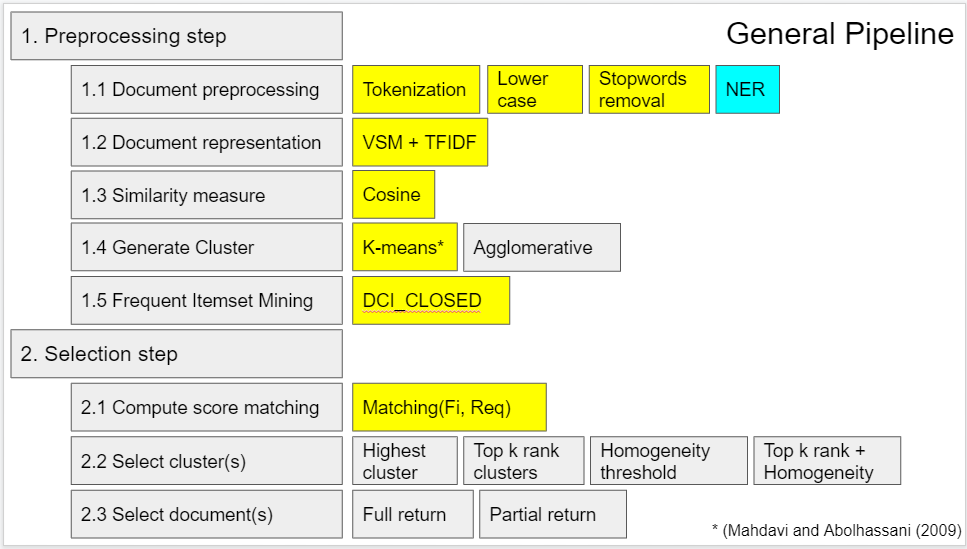

Document preprocessing

In [1]:
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
from string import punctuation
from collections import OrderedDict
from nltk.probability import FreqDist

In [2]:
# função para obter a entrada do dci_closed = CLOSED_SET, PRE_SET, POST_SET
def extract_itemsets(cluster, min_supp):
    pre_set = []

    # pegar itens que estão em todos os documentos = c(∅)
    closed_set = []
    for item in pre_set:
        ver = 0
        for doc in cluster:
            if item in doc:
                ver += 1

        if ver == len(cluster):
            closed_set.append(item)

    # seleção dos termos frequentes
    f1 = []
    _ = [f1.append(item) for doc in cluster for item in doc if supp([item], cluster) >= min_supp and item not in f1]

    # itens frequentes que não estão no closed = F1 \ c(∅)
    post_set = [item for item in f1 if item not in closed_set]

    return closed_set, pre_set, post_set


def dci_closed(closed_set, pre_set, post_set, cluster, min_supp):
    subsets = []
    for i in range(len(post_set)):
        new_gen = closed_set.copy()
        new_gen.append(post_set[i])
        if supp(new_gen, cluster) >= min_supp:
            if not is_dup(new_gen, pre_set, cluster):
                closed_set_new = new_gen.copy()
                post_set_new = []
                for j in range(i+1, len(post_set)):
                    if set(g(new_gen, cluster)).issubset(g(post_set[j], cluster)):
                        closed_set.append(post_set[j])
                    else:
                        post_set_new.append(post_set[j])

                subsets.append(closed_set_new)
                retorno = dci_closed(closed_set_new, pre_set, post_set_new, cluster, min_supp)
                subsets.extend(retorno)
                pre_set.append(post_set[i])

    return subsets


# cálculo do support
def supp(itemset, cluster):
    support = 0
    for doc in cluster:
        if set(itemset).issubset(doc):
            support += 1
    return support/len(cluster)


# checagem de duplicados
def is_dup(new_gen, pre_set, cluster):
    for j in pre_set:
        if set(g(new_gen, cluster)).issubset(g(j, cluster)):
            return True

    return False


def g(itemset, cluster):
    lista_de_trans = []
    for doc in range(len(cluster)):
        if set(itemset).issubset(cluster[doc]):
            lista_de_trans.append(doc)

    return lista_de_trans

In [3]:
'''
    Retriever from 
    `Fast and Effective Cluster-based Information Retrieval 
        Using Frequent Closed Itemsets` 
'''
class Retriever:
    def __init__(self, docs, random_state = 0):
        self.docs = docs
        self.length = len(docs)
        self.random_state = random_state
        self.clusters = list()
        return

    '''
        Runs preprocessing step
    '''
    def build(self, k, min_sup = 0.5, stopwords_lang = "portuguese", domain_stopwords = None, verbose=False):
        self.k = k

        # Generating clean documents (no stopwords)
        if (verbose):
            print("> Building Vector Space Model...")
        self.vsm = self._vsm_build(stopwords_lang, domain_stopwords)
        
        # Applying K-Means to the VSM
        if (verbose):
            print("> Running K-Means...")
        self.doc_labels = self._cluster_build(k)         
        
        # Building clusters with documents
        if (verbose):
            print("> Separatign clusters...")
        for i in range(k):
            new_cluster = Cluster(label=i)
            self.clusters.append(new_cluster)
        for i in range(self.length):
            self.clusters[self.doc_labels[i]].addDoc(self.docs[i])

        # Cleaning and tokenizing words in clusters and building itemsets
        # with DCI-Closed
        if (verbose):
            print("> Running DCI-Closed...")
        for i in range(k):
            self.clusters[i].DCIClosed(self.stopwords, min_sup, lang = stopwords_lang)
            if (verbose):
                print(f"\t>> Finished cluster {i} itemsets")
        return
    
    '''
        Looks for documents that match a given query
         (Information Retrieval step)
        cluster_select: highest | ranking | homogeneity | hr
        document_select: full | partial 
    '''
    def search(self, query, cluster_select="highest", doc_select="full", k=1, mu=None):
        # Generating word frequency dictionary
        word_dict = self._tokenize_query(query)

        # Matching words with itemsets
        matching = {}
        for i in range(self.k):
            value = 0
            for term in word_dict.keys():
                value += self._search_term(term, self.clusters[i].itemsets)
            matching['Assunto, F' + str(i + 1)] = value

        # Ranking clusters based on scores 
        scores = list(matching.values())
        ranked_clusters = [x for _, x in sorted(zip(scores,self.clusters), key=lambda pair: pair[0])]
        ranked_clusters.reverse()
        
        # Selecting clusters based on cluster_select method
        selected_clusters = list()
        if (cluster_select == "highest"):
            selected_clusters.append(ranked_clusters[0])
        elif (cluster_select == "ranking"):
            selected_clusters = ranked_clusters[:k]
        elif (cluster_select == "homogeneity"):
            for i,score in enumerate(sorted(scores)):
                if (score >= mu):
                    selected_clusters.append(ranked_clusters[i])
        elif (cluster_select == "ht"):
            for i,score in enumerate(sorted(scores)[:k]):
                if (score >= mu):
                    selected_clusters.append(ranked_clusters[i])
        print(f"Selected {len(selected_clusters)} Clusters")
        
        
        # Selecting documents inside selected clusters based on doc_select method
        selected_docs = list()
        if (doc_select == "full"):
            for c in selected_clusters:
                selected_docs += c.elements

        return selected_docs

    def _tokenize_query(self, query):
        terms = word_tokenize(query.lower())
        terms = [word for word in terms if word not in self.stopwords]
        
        # Build word frequency dict
        term_frequency = OrderedDict(sorted(FreqDist(terms).items(), key=lambda x: x[1],reverse=True))
        return term_frequency

    def _search_term(self, term, itemset):
        if (len(itemset)) != 0:
            for item in itemset:
                if term in item:
                    return 1
        return 0

    '''
        Generates Vector Space Model using TF-IDF
        and ignoring selected stopwords
    '''
    def _vsm_build(self, stopwords_lang = "portuguese", domain_stopwords = None):
        self.stopwords = nltk.corpus.stopwords.words(stopwords_lang)
         
         # Adding domain specific stopwords
        if (domain_stopwords != None):
            self.stopwords.extend(domain_stopwords)
        self.stopwords.extend(list(punctuation))
    
        # Generating Vecotor Space Model
        vectorizer = TfidfVectorizer(stop_words=self.stopwords)
        vsm = vectorizer.fit_transform(self.docs)

        return vsm

    def _cluster_build(self, k):
        kmeans = KMeans(n_clusters=k, random_state=self.random_state, max_iter=1)
        clusters = kmeans.fit(self.vsm)
        return clusters.labels_



'''
    Cluster
'''
class Cluster:
    def __init__(self,label):
        self.label = label
        self.elements = list()
        self.size = 0
        return
    
    def addDoc(self, doc):
        #print(f"=====\nAdding to cluster {self.label}>> {doc}\n=====\n")
        self.size += 1
        self.elements.append(doc)
        return

    def DCIClosed(self, stopwords, min_sup = 0.5, lang = "portuguese"):
        self._bagOfWords_build(stopwords, lang)

        closed_set, pre_set, post_set = extract_itemsets(self.words, min_sup)
        self.itemsets = dci_closed(closed_set, pre_set, post_set, self.words, min_sup)        
        return

    def _bagOfWords_build(self, stopwords, lang = "portuguese"):
        clean_words = list()
        for doc in self.elements:
            doc = doc.replace("\r\n", " ")
            doc_words = [word.lower() for word in word_tokenize(doc, language=lang) if word not in stopwords]
            clean_words.append(doc_words)
        self.words = clean_words
        #print(clean_words)
        return

In [4]:
import pandas as pd

# Selecting list of documents to be read
input_file = "./data/proposicao-tema-completo-sem-duplicado-2019.csv"      # must be replaced with a file containing the corpus
df = pd.read_csv(input_file, delimiter=',', encoding="utf-8")

In [5]:
df.head(10)

,codProposicao,txtNome,txtEmenta,txtExplicacaoEmenta,txtIndexacao,imgArquivoTeorPDF,idTema
0,308880,PL 2441/2019,Dá nova redação aos arts. 20 e 123 do Decreto-...,"Exige dos corretores de seguro e resseguro, pe...","Alteração, Lei do Seguro Privado, obrigatoried...",PROJETO DE LEI\r\nDá nova redação aos arts. 20...,40
1,317970,PL 2037/2019,"Altera a Lei nº 8.666, de 21 de junho de 1993,...",...,"Alteração, Lei das Licitações, proibição, ante...","PROJETO DE LEI No , DE 2006\r\n(...",34
2,427339,PL 2439/2019,"Altera o art. 125 da Lei nº 9.279, de 14 de ma...",...,"Alteração, Nova Lei de Patentes, critérios, re...","PROJETO DE LEI No , DE 2009\r\n(Do...",66
3,501638,PL 402/2019 (,Institui o Programa Cidade Amiga do Idoso. ...,...,"Criação, Programa Cidade Amiga do Idoso, quali...","PROJETO DE LEI no , DE 2011 \r\n(Do Sr. ...",44
4,512431,PL 2442/2019,Proíbe a utilização de mensagens subliminares ...,"Altera a Lei nº 4.117, de 1962 ...","Alteração, Código Brasileiro de Telecomunicaçõ...",\r\n \r\nCÂMARA DOS DEPUTADOS \r\n \r\nPROJET...,37
5,530357,PL 2440/2019,Obriga os fabricantes de aparelho celular a di...,...,"Obrigatoriedade, fabricante, assistência técni...","PROJETO DE LEI Nº , DE 2011 \r\n(Da Sra. ...",67
6,538196,PL 6610/2019,Dispõem sobre a proibição da eliminação de cãe...,...,"Proibição, zoonose, eliminação, cão, gato. ...","\r\nPROJETO DE LEI Nº, DE 2012 \r\n(DO Sr. RI...",56
7,539990,PL 6003/2019,"Altera a Lei nº 8.934, de 18 de novembro de 19...",...,"Alteração, Lei de Registro Público de Empresas...",CÂMARA DOS DEPUTADOS \r\n ...,66
8,559138,PL 6606/2019,Dispõe sobre a Política Nacional de Economia S...,...,"Diretrizes, Política Nacional de Economia Soli...","PROJETO DE LEI Nº , DE DE ...",40
9,601739,PL 6054/2019,Acrescenta parágrafo único ao art. 82 do Códig...,...,"Alteração, Código Civil, natureza jurídica, tu...",\r\n \r\nCAMARA DOS DEPUTADOS \r\n \r\n \r\n ...,42


In [6]:
df.txtEmenta

0       Dá nova redação aos arts. 20 e 123 do Decreto-...
1       Altera a Lei nº 8.666, de 21 de junho de 1993,...
2       Altera o art. 125 da Lei nº 9.279, de 14 de ma...
3       Institui o Programa Cidade Amiga do Idoso.    ...
4       Proíbe a utilização de mensagens subliminares ...
                              ...                        
5455    Estabelece a obrigação de os sítios de interne...
5456    Altera a Lei nº 6.088, de 16 de julho de 1974,...
5457    Altera a Lei nº 9.656, de 3 de junho de 1998 (...
5458    Altera a Lei nº 12.213, de 20 de janeiro de 20...
5459                                            txtEmenta
Name: txtEmenta, Length: 5460, dtype: object

In [7]:
#NUM_DATA = 1000

data = df.imgArquivoTeorPDF.dropna()        # replace with the desired column name
data = data.to_numpy()

In [8]:
NUM_CLUSTER = 19

# Running preprocessing step
model = Retriever(data)
model.build(k=NUM_CLUSTER, verbose=True)

> Building Vector Space Model...
> Running K-Means...
> Separatign clusters...
> Running DCI-Closed...


KeyboardInterrupt: 

In [ ]:
df_assunto = pd.read_csv("./data/dados-conle-anonimizado-assunto-notnull.csv", delimiter=";", encoding="utf-8")
df_assunto.rename(columns={"numero-proposicao-sileg":"txtNome"}, inplace=True)
df_assunto.head(10)

In [ ]:
# Obtem o nome do texto no df
def get_name(df, doc):
    return df[df.txtEmenta==doc].txtNome.to_numpy()[0].strip()

In [ ]:
arr_assunto = df_assunto.to_numpy()
y,X = arr_assunto[:,0],arr_assunto[:,1]
y = [i.strip() for i in y]

In [ ]:
results = list()
for l,x in zip(y,X):
    docs = model.search(x, cluster_select="highest",doc_select="full")
    labels = [get_name(df,d) for d in docs]
    
    result = {"query":x,"txtNome":l, "hightest_cluster":[[a, b] for a,b in zip(labels, docs)]}
    results.append(result)
    '''
    if (l in labels):
        print("===ENCONTRADO===")
    else:
        print("===NÃO ENCONTRADO===")
    print("query:",x)
    print("----------------\n")
    '''

In [ ]:
import json
with open("highest_cluster_k19.json", "w+") as fp:
    json.dump(results, fp)

In [ ]:
teste = pd.read_json("highest_cluster_k19.json")
teste